In [11]:
import cv2
import tensorflow as tf
import numpy as np  
import os

In [28]:
model_name = 'pneumonia_model_img_144_lr_1e-5_epochs_50_best.bin'

In [29]:
# load model and predict some some external photo
IMG_SIZE=144
labels = ["NORMAL", "PNEUMONIA"]
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model(model_name)

In [17]:
prediction = model.predict([prepare("./test/NORMAL/IM-0001-0001.jpeg")])

print(labels[int(prediction[0])])

1/1 [==============================] - 1s 842ms/step
NORMAL


C:\Users\USER\AppData\Local\Temp\ipykernel_19536\3128855185.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(labels[int(prediction[0])])


In [18]:
prediction = model.predict([prepare("./test/PNEUMONIA/person100_bacteria_475.jpeg")])
print(labels[int(prediction[0])])

1/1 [==============================] - 0s 167ms/step
PNEUMONIA


C:\Users\USER\AppData\Local\Temp\ipykernel_19536\181650012.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(labels[int(prediction[0])])


In [30]:
def get_data_train(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        print(path)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                resize_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resize_img_array, class_num])
            except Exception as e:
                print(e)
    
    return np.array(data, dtype=object)

In [31]:
test_folder="./test"
test = get_data_train(test_folder)

./test\NORMAL
./test\PNEUMONIA


In [32]:
X_test,y_test = [],[]
for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

In [33]:
X_test = np.array(X_test)/255.0
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)


In [34]:

prediction = (model.predict(X_test) > 0.5).astype("int32")
prediction = prediction.reshape(1, -1)[0]
prediction[:15]

20/20 [==============================] - 3s 95ms/step


array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])

In [35]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return{"TP": TP, "FP": FP, "TN": TN, "FN": FN}

In [36]:
cm = perf_measure(y_test, prediction)
cm

{'TP': 370, 'FP': 76, 'TN': 158, 'FN': 20}

In [37]:
def print_metrics(cm):
  print("accuracy: ", (cm["TP"] + cm["TN"]) / (cm["TP"] + cm["TN"] + cm["FP"] + cm["FN"]))
  print("precision: ", cm["TP"] / (cm["TP"] + cm["FP"]))
  print("recall: ", cm["TP"] / (cm["TP"] + cm["FN"]))
  print("specificity: ", cm["TN"] / (cm["TN"] + cm["FP"]))
  print("f1 score: ", 2 * cm["TP"] / (2 * cm["TP"] + cm["FP"] + cm["FN"]))
print_metrics(cm)

accuracy:  0.8461538461538461
precision:  0.8295964125560538
recall:  0.9487179487179487
specificity:  0.6752136752136753
f1 score:  0.8851674641148325


<Axes: >

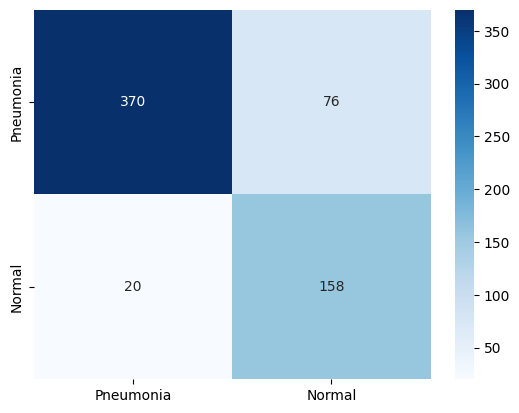

In [38]:
import seaborn as sns

sns.heatmap([[cm["TP"], cm["FP"]], [cm["FN"], cm["TN"]]], annot=True, fmt="d", cmap="Blues", xticklabels=["Pneumonia", "Normal"], yticklabels=["Pneumonia", "Normal"])